# Changing the spectra per epoch

In [37]:
import os
import numpy as np
from astropy.io import fits
from astropy import units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
import os
from concurrent.futures import ThreadPoolExecutor
import time
import gc
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
from tensorflow.keras.callbacks import EarlyStopping




In [9]:

def generate_file_list(limit_per_dir = 10000):
    spectra_dirs = {
        "gal_spectra": 0,  # Label 0 for galaxies
        "star_spectra": 1,  # Label 1 for stars
        "agn_spectra": 2,   # Label 2 for AGNs
        "bin_spectra": 3    # Label 3 for binary stars
    }

    file_list = []
    labels = []

    print("Gathering FITS files...")
    for dir_name, label in spectra_dirs.items():
        dir_path = os.path.join(os.getcwd(), dir_name)
        dir_files = []

        # Collect all files in the directory
        for root, dirs, files in os.walk(dir_path):
            for file in files:
                file_path = os.path.join(root, file)
                dir_files.append(file_path)
        
        # Randomly select files up to the limit
        if len(dir_files) > limit_per_dir:
            selected_files = random.sample(dir_files, limit_per_dir)
        else:
            selected_files = dir_files
        
        # Append selected files and their labels
        file_list.extend(selected_files)
        labels.extend([label] * len(selected_files))

    print(f"Total spectra files collected: {len(file_list)}")
    return file_list, labels



def load_spectra(file_list, known_rows=None):
    spectra_data = []
    if known_rows is None:
        known_rows = np.inf
        for file_path in tqdm(file_list, desc="Finding min rows", unit="file"):
            try:
                with fits.open(file_path) as hdul:
                    spectra = hdul[0].data[0]
                    known_rows = min(known_rows, len(spectra))
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    print(f"\nLoading spectra (truncated to {known_rows} rows)...")
    for file_path in tqdm(file_list, desc="Loading spectra", unit="file"):
        try:
            with fits.open(file_path) as hdul:
                spectra = hdul[0].data[0][:known_rows]
                normalized_spectra = normalize_spectra(spectra)
                spectra_data.append(normalized_spectra)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    spectra_data = np.array(spectra_data)
    return spectra_data

def create_dataset(file_list, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((file_list, labels))

    def load_and_parse(file_path, label):
        spectra = tf.py_function(load_spectra, [file_path], tf.float32)
        return spectra, label

    dataset = dataset.map(load_and_parse, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(file_list)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset
def split_dataset(file_list, labels, val_split=0.2):
    total_size = len(file_list)
    val_size = int(val_split * total_size)
    
    indices = np.random.permutation(total_size)
    train_indices, val_indices = indices[val_size:], indices[:val_size]
    
    train_files = [file_list[i] for i in train_indices]
    train_labels = [labels[i] for i in train_indices]
    val_files = [file_list[i] for i in val_indices]
    val_labels = [labels[i] for i in val_indices]
    
    return train_files, train_labels, val_files, val_labels

def normalize_spectra(spectra):
    """Normalize spectra by dividing by the mean and applying the natural logarithm."""
    mean_value = np.mean(spectra)
    std_value = np.std(spectra)
    min_value = np.min(spectra)
    if std_value == 0:
        print("Warning: Standard deviation is zero, cannot normalize spectra.")
        return spectra  # Avoid division by zero
    normalized_spectra = ((spectra - min_value  + 0.01) / (mean_value - min_value + 0.01)) - 1 # min_value is added to avoid negative values
    return normalized_spectra

def load_single_spectrum(file_path, target_length=len_):
    """Load and normalize a single spectrum from a FITS file, truncating or padding to target_length."""
    try:
        with fits.open(file_path) as hdul:
            spectra = hdul[0].data[0]
            spectra = normalize_spectra(spectra)
            
            # Truncate or pad spectra to ensure uniform length
            if len(spectra) > target_length:
                spectra = spectra[:target_length]  # Truncate
            else:
                spectra = np.pad(spectra, (0, max(0, target_length - len(spectra))), mode='constant')  # Pad with zeros
            
            return spectra
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None  # Return None if there's an error

def load_all_spectra_parallel(file_list, target_length=3748, max_workers_=512):
    """Load and normalize spectra in parallel using ThreadPoolExecutor."""
    spectra_data = []
    
    with ThreadPoolExecutor(max_workers=max_workers_) as executor:
        # Use ThreadPoolExecutor to parallelize the loading of FITS files
        results = list(tqdm(executor.map(lambda f: load_single_spectrum(f, target_length), file_list), 
                            total=len(file_list), desc="Loading spectra"))

    # Filter out None results (in case any files failed to load)
    spectra_data = [spectrum for spectrum in results if spectrum is not None]

    return np.array(spectra_data)

## Convnet function

In [4]:
def create_convnet(input_shape, num_classes, 
                   num_filters=[128, 128, 128, 128, 128, 128, 128, 128], 
                   kernel_size=(9,),
                   dense_units=128, 
                   dropout_rate=0.5,
                   padding='same'):
    model = tf.keras.models.Sequential()
    
    # First convolutional layer
    model.add(tf.keras.layers.Conv1D(filters=num_filters[0], kernel_size=kernel_size, 
                                     activation='relu', input_shape=input_shape, padding=padding))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Additional convolutional layers
    for filters in num_filters[1:]:
        model.add(tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, 
                                         activation='relu', padding=padding))
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    # Flatten the output and add dense layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=dense_units, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    
    # Output layer
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

    # Optimizer and loss function
    optimizer_ = tf.keras.optimizers.AdamW(learning_rate=1e-4)

    # Compile the model
    model.compile(optimizer=optimizer_, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

In [7]:
len_ = 3748
file_list, labels = generate_file_list(limit_per_dir=1)

# Now use these datasets to train the model
convnet_model = create_convnet(input_shape=(len_-10, 1), num_classes=len(set(labels)))

convnet_model.summary()

Gathering FITS files...
Total spectra files collected: 4


/home/jcwind/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 3738, 128)      │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 1869, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 1869, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 934, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 934, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 467, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 467, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 233, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 233, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 116, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 116, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 58, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 58, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 29, 128)        │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       229,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,264,388 (4.82 MB)

 Trainable params: 1,264,388 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Create TensorFlow datasets using the loaded data
def create_tf_dataset(spectra_data, labels, batch_size=64):
    dataset = tf.data.Dataset.from_tensor_slices((spectra_data, labels))
    dataset = dataset.shuffle(buffer_size=len(spectra_data)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [34]:
def removenan(train_spectra, train_labels, val_spectra, val_labels): 
   # Convert lists to NumPy arrays (remove first 10 spectra to avoid excess NaN values)
    train_spectraa = np.array(train_spectra[10:, :])
    train_labelsa = np.array(train_labels[10:])

    val_spectraa = np.array(val_spectra[10:, :])
    val_labelsa = np.array(val_labels[10:])

    # Remove nan values from the spectra
    mask_train = ~np.isnan(train_spectraa).any(axis=1)
    train_spectranan = train_spectraa[mask_train]
    train_labelsnan = train_labelsa[mask_train]

    mask_val = ~np.isnan(val_spectraa).any(axis=1)
    val_spectranan = val_spectraa[mask_val]
    val_labelsnan = val_labelsa[mask_val]

    del val_spectraa, val_labelsa, mask_val, train_spectraa, train_labelsa, mask_train
    gc.collect()

    # Create TensorFlow datasets
    train_dataset = create_tf_dataset(train_spectranan, train_labelsnan)
    val_dataset = create_tf_dataset(val_spectranan, val_labelsnan)

    del train_spectranan, train_labelsnan
    gc.collect()
    return train_dataset, val_dataset

In [35]:
def generate_random_dataset(lim_per_label = 2000):
    # Example usage:
    file_list, labels = generate_file_list(limit_per_dir=lim_per_label)
    # Convert labels to numpy array
    labels = np.array(labels)
    # Continue with creating train/validation datasets
    train_files, train_labels, val_files, val_labels = split_dataset(file_list, labels)
    # Load training and validation spectra in parallel
    train_spectra = load_all_spectra_parallel(train_files, target_length=len_)
    val_spectra = load_all_spectra_parallel(val_files, target_length=len_)
    # Create TensorFlow datasets
    train_dataset, val_dataset = removenan(train_spectra, train_labels, val_spectra, val_labels)
    return train_dataset, val_dataset


In [36]:
train_dataset, val_dataset = generate_random_dataset(lim_per_label = 2000)

Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 558.30it/s]


In [38]:
# Function to train the model with the training and validation datasets
def train_convnet(model, lim_per_label = 2000, epochs=1, batch_size=32, patience=5):
    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    train_dataset, val_dataset = generate_random_dataset(lim_per_label = lim_per_label)
    # Fit the model
    history = model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping])
    
    return history

In [39]:
def train_convnet_many_times(model, epochs_per_run=1, batch_size=32, num_runs=10):
    histories = []
    for i in range(num_runs):
        print(f"Training run {i+1}/{num_runs}...")
        history = train_convnet(model, epochs=epochs_per_run , batch_size=batch_size)
        histories.append(history)
    return histories

In [40]:
histories = train_convnet_many_times(convnet_model, epochs_per_run=1, batch_size=32, num_runs=25)

Training run 1/10...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 682.44it/s] 
I0000 00:00:1727346751.292003   65240 service.cc:146] XLA service 0x7f4efc013200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727346751.292100   65240 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-09-26 11:32:31.368222: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-26 11:32:31.734574: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


  5/100 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.2686 - loss: 1.3861

I0000 00:00:1727346758.987943   65240 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.4563 - loss: 1.2045

2024-09-26 11:32:50.758215: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_203', 4 bytes spill stores, 4 bytes spill loads



100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.4574 - loss: 1.2027 - val_accuracy: 0.6730 - val_loss: 0.8122
Training run 2/10...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 610.94it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6604 - loss: 0.8112 - val_accuracy: 0.7063 - val_loss: 0.7358
Training run 3/10...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 585.40it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6837 - loss: 0.7899 - val_accuracy: 0.6893 - val_loss: 0.7107
Training run 4/10...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 684.89it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6793 - loss: 0.7634 - val_accuracy: 0.6937 - val_loss: 0.6925
Training run 5/10...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 655.58it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6967 - loss: 0.7115 - val_accuracy: 0.7296 - val_loss: 0.6041
Training run 6/10...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 664.63it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7053 - loss: 0.6555 - val_accuracy: 0.7119 - val_loss: 0.6317
Training run 7/10...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 612.58it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7069 - loss: 0.7382 - val_accuracy: 0.7346 - val_loss: 0.6121
Training run 8/10...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 603.16it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7158 - loss: 0.6411 - val_accuracy: 0.7503 - val_loss: 0.5400
Training run 9/10...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 705.91it/s]


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.7358 - loss: 0.5939 - val_accuracy: 0.7535 - val_loss: 0.5502
Training run 10/10...
Gathering FITS files...
Total spectra files collected: 8000


Loading spectra: 100%|██████████| 1600/1600 [00:02<00:00, 590.46it/s] 


100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7407 - loss: 0.5653 - val_accuracy: 0.7491 - val_loss: 0.5437


In [46]:
# Save the model
convnet_model.save('convnet_model_v1.keras')

50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step
Confusion Matrix:
[[379   3  18   2]
 [  7 247   6 139]
 [ 74   9 331   4]
 [  9 100   7 255]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       402
           1       0.69      0.62      0.65       399
           2       0.91      0.79      0.85       418
           3       0.64      0.69      0.66       371

    accuracy                           0.76      1590
   macro avg       0.76      0.76      0.76      1590
weighted avg       0.77      0.76      0.76      1590



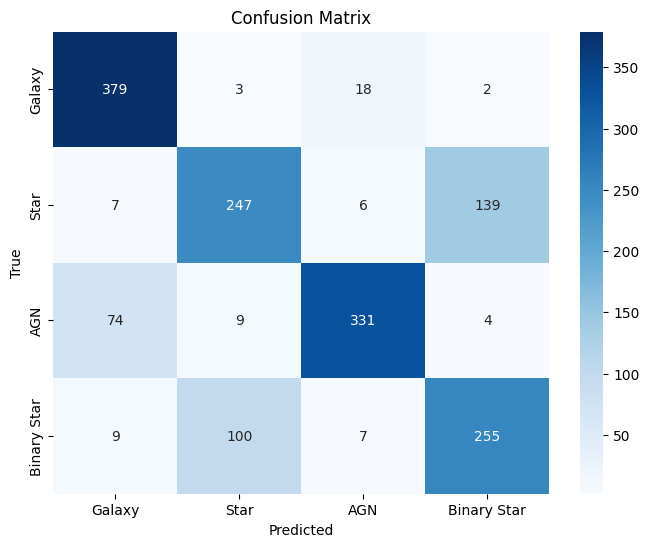

In [44]:
# Make predictions on the validation/test dataset
val_predictions = convnet_model.predict(val_spectranan)

# Convert the predictions to class labels (assuming one-hot encoding)
predicted_labels = np.argmax(val_predictions, axis=1)

# Convert true labels if they are in one-hot encoded format
true_labels = np.array(val_labelsnan)  # Assuming val_labels is already numeric


# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, print a classification report for more metrics
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'], yticklabels=['Galaxy', 'Star', 'AGN', 'Binary Star'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()